# Working with FB Prophet
##  [Trend Changepoints](https://facebookincubator.github.io/prophet/docs/trend_changepoints.html) example from FB page  

Lok at time series of daily page views for the Wikipedia page for Peyton Manning. The csv is available [here](https://github.com/facebookincubator/prophet/blob/master/examples/example_wp_peyton_manning.csv)

In [1]:
#wp_R_dataset_url = 'https://github.com/facebookincubator/prophet/blob/master/examples/example_wp_R.csv'
wp_peyton_manning_filename = '../datasets/example_wp_peyton_manning.csv'

In [2]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

### import the data and transform to log-scale

In [3]:
df = pd.read_csv(wp_peyton_manning_filename)
# transform to log scale
df['y']=np.log(df['y'])
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


Looking at this dataset, it is clear that real time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. However, if you wish to have finer control over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history), then there are several input arguments you can use.

### Automatic changepoint detection in Prophet
<hr>

Prophet detects changepoints by first specifying a large number of _potential changepoints_ at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate of changes. This is equivalent to L1 regularization, meaning that Prophet has a large number of _possible_ places where the rate can change, but will use as few of them as possible. Consider the Peyton Manning forecast in the Quickstart example. By default, Prophet specifies 25 potential changepoints which are uniformly placed in the first 80% of the time series. 

In [4]:
m = Prophet()
m.fit(df);


In [5]:
future = m.make_future_dataframe(periods=365) 
forecast = m.predict(future)
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
3265,2017-01-15,1.121836,7.195772,1.018015,1.018015,6.875198,7.586228,7.493022,8.965502,0.048265,0.048265,0.048265,0.969750,0.969750,0.969750,1.018015,8.213787
3266,2017-01-16,1.122173,7.194756,1.344120,1.344120,6.873483,7.586598,7.755313,9.296140,0.352314,0.352314,0.352314,0.991806,0.991806,0.991806,1.344120,8.538876
3267,2017-01-17,1.122511,7.193741,1.132552,1.132552,6.870818,7.586121,7.615190,9.080839,0.119636,0.119636,0.119636,1.012916,1.012916,1.012916,1.132552,8.326293
3268,2017-01-18,1.122848,7.192725,0.966205,0.966205,6.868154,7.585872,7.437230,8.947432,-0.066672,-0.066672,-0.066672,1.032877,1.032877,1.032877,0.966205,8.158930
3269,2017-01-19,1.123186,7.191709,0.979189,0.979189,6.865534,7.586771,7.449006,8.927116,-0.072254,-0.072254,-0.072254,1.051443,1.051443,1.051443,0.979189,8.170898


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

Below the dashed lines show where the potential changepoints wer placed.

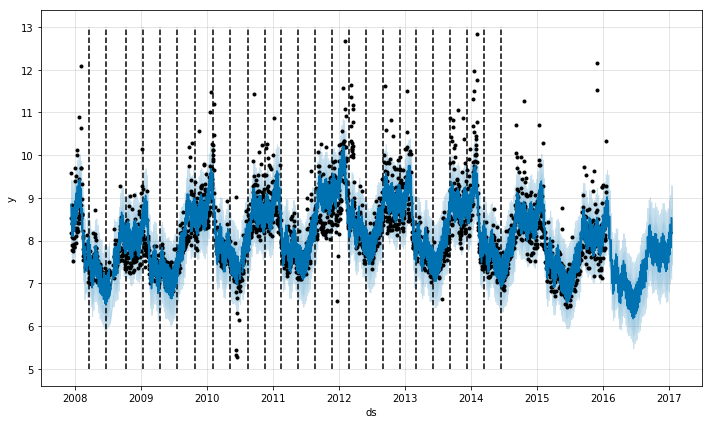

In [21]:
ax = m.plot(forecast)
for ts in m.changepoints.values:
    plt.vlines(x=ts, ymin=5, ymax=13, linestyles='--')

Even though we have a lot of places where the rate can possibly change because of the sparse prior, most of these changepoints are unused (i.e. 0). We can determine this by plotting the magnitude of the rate change at each changepoint:

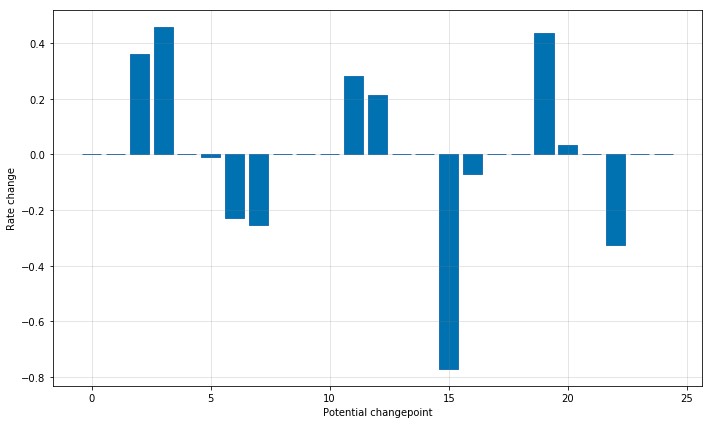

In [31]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#2072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

The number of potential changepoints can be set using the argument `n_changepoints`, but this is better tuned by adjusting the regularization.

<hr>
### Adjusting trend flexibility
If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument `changepoint_prior_scale`. By default, this parameter is set to 0.05. Increasing it will make the trend _more_ flexible:

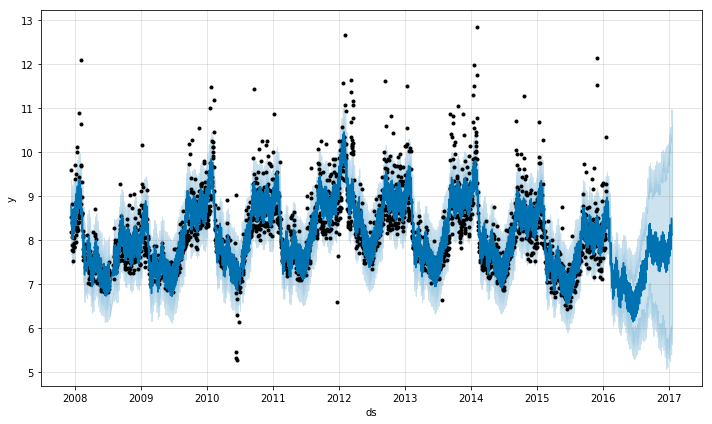

In [32]:

m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(df).predict(future)
m.plot(forecast);

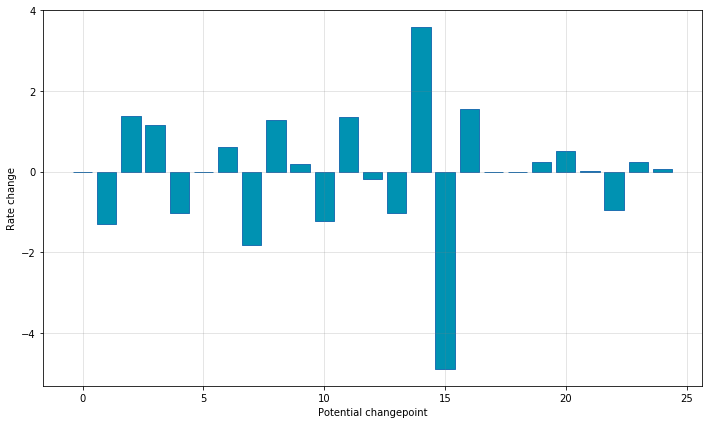

In [33]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0092B2', edgecolor='#2072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

Whereas decreasing it will make the trend _less_ flexible

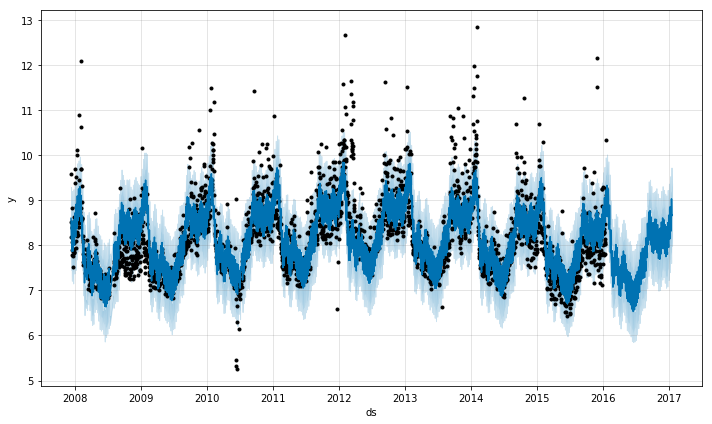

In [34]:
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(df).predict(future)
m.plot(forecast);

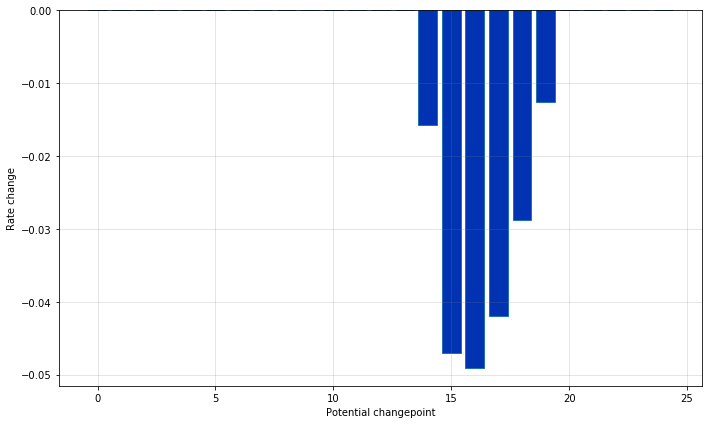

In [35]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0032B2', edgecolor='#2072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

###  Specifying the locations of the changepoints

If you wish, rather than using automatic changepoint detection you can manually specify the locations of potential changepoints with the `changepoints` argument.

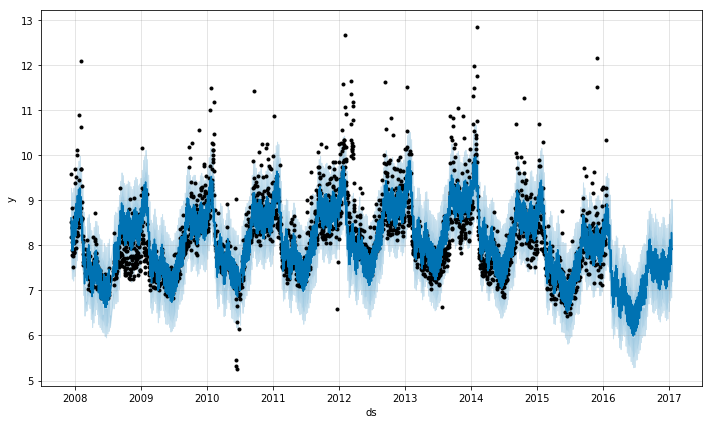

In [36]:
m = Prophet(changepoints=['2014-01-01'])
forecast = m.fit(df).predict(future)
m.plot(forecast);